### **Laboratorio 1**

### **Carga de Datos de Importacion Hidrocarburos**

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

### **Datos de Importacion** 

In [22]:
df_import_2024 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx", skiprows=6)
df_import_2025 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx", skiprows=6)

print(df_import_2024.columns.tolist())

['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior', 'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas', 'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano', 'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido', 'Total importación']


In [23]:

df_import_2024["Diesel"] = df_import_2024["Diesel alto azufre"] + df_import_2024["Diesel bajo azufre"]
df_import_2025["Diesel"] = df_import_2025["Diesel bajo azufre"]


In [24]:

columnas_deseadas = [
    "Fecha",
    "Gasolina Regular",
    "Gasolina Superior",
    "Diesel",
    "Gas Licuado De Petróleo"
]


df_import_2024.columns = df_import_2024.columns.str.strip().str.title()
df_import_2025.columns = df_import_2025.columns.str.strip().str.title()


df_2024_cols = df_import_2024[columnas_deseadas].copy()
df_2025_cols = df_import_2025[columnas_deseadas].copy()


df_total = pd.concat([df_2024_cols, df_2025_cols], ignore_index=True)


df_total["Fecha"] = pd.to_datetime(df_total["Fecha"], errors="coerce")


df_importacion_total = df_total.dropna()


df_importacion_total.set_index("Fecha", inplace=True)



In [25]:
df_importacion_total.to_csv("importacion_completa.csv", index=True)
# Cambiar nombre de columna
df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)

airPas = df_importacion_total["Gasolina regular"]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_6564\1058275361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)


In [26]:
df_importacion_total.head()

,Gasolina regular,Gasolina Superior,Diesel,Gas Licuado De Petróleo
Fecha,,,,
2001-01-01,177776.50,373963.96,566101.99,194065.738095
2001-02-01,123115.99,243091.07,489525.80,170703.380952
2001-03-01,161726.42,312084.38,575559.68,161837.371429
2001-04-01,127338.74,285054.89,437745.42,163048.642857
2001-05-01,168730.19,300913.67,552609.13,171518.861905


In [27]:
df_importacion_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2001-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina Superior        293 non-null    float64
 2   Diesel                   293 non-null    float64
 3   Gas Licuado De Petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


## **Inciso 3**

### **Serie de Tiempo Gasolina Regular**

##### **Inicio, fin y frecuencia**

In [28]:
serie = df_importacion_total["Gasolina regular"]
inicio = serie.index.min()
fin = serie.index.max()
frecuencia = pd.infer_freq(serie.index)

print("Inicio:", inicio)
print("Fin:", fin)
print("Frecuencia:", frecuencia)


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


#### **Gráfico de la serie**

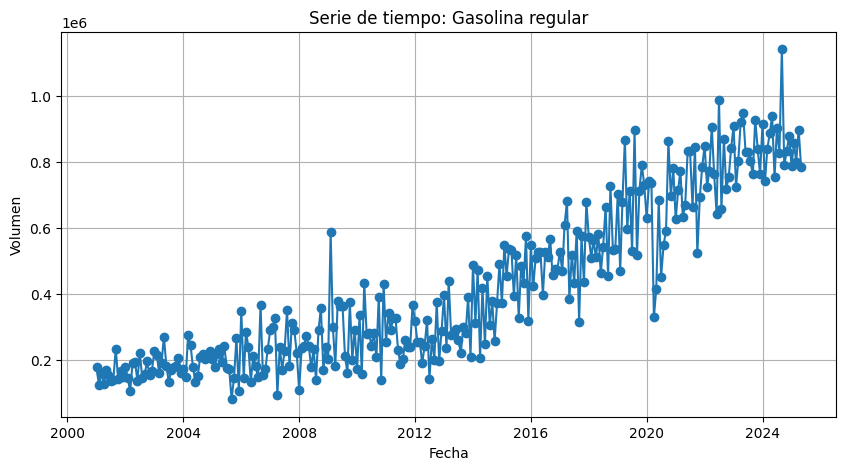

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(serie, marker='o', linestyle='-')
plt.title("Serie de tiempo: Gasolina regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


#### **Descomposición de la serie**

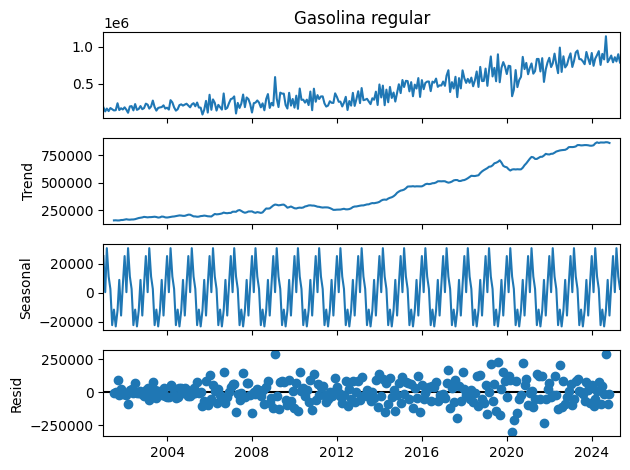

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model="additive", period=12)
descomposicion.plot()
plt.tight_layout()
plt.show()


Al descomponer la serie de tiempo de gasolina regular en sus componentes —tendencia, estacionalidad y residuo— se pueden observar varios comportamientos importantes. La tendencia muestra un crecimiento sostenido a lo largo del tiempo, particularmente acelerado a partir del año 2015, lo que indica que el volumen importado ha aumentado de forma constante en los últimos años. En cuanto al componente estacional, se identifica un patrón regular y repetitivo a lo largo de cada año. Este comportamiento estacional sugiere que existen ciertos meses en los que el consumo o la importación de gasolina regular tiende a aumentar o disminuir de manera sistemática, lo cual podría estar vinculado a factores climáticos, económicos o sociales.l componente de residuo no presenta una estructura clara, pero se observa que su variabilidad parece incrementarse en los años más recientes. Esto sugiere un posible aumento en la varianza, lo que es importante al analizar la estacionariedad.

Con base en estos componentes, se puede concluir que la serie no es estacionaria en media, debido a la presencia de una tendencia creciente. Asimismo, la estacionariedad en varianza también es cuestionable, ya que la amplitud de las fluctuaciones residuales tiende a crecer con el tiempo. Por lo tanto, antes de aplicar modelos de pronóstico, sería recomendable transformar la serie para lograr condiciones más cercanas a la estacionariedad.

#### **Transformar la serie**

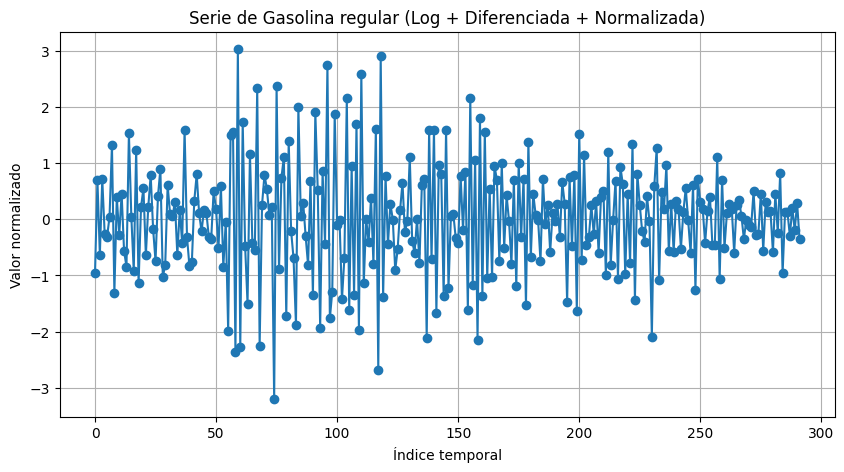

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Paso 1: Logaritmo
serie_log = np.log(df_importacion_total["Gasolina regular"])

# Paso 2: Diferenciación para estacionariedad
serie_estacionaria = serie_log.diff().dropna()

# Paso 3: Normalización con StandardScaler
scaler = StandardScaler()
serie_normalizada = scaler.fit_transform(serie_estacionaria.values.reshape(-1, 1))

# Paso 4: Graficar serie normalizada
plt.figure(figsize=(10, 5))
plt.plot(serie_normalizada, linestyle='-', marker='o')
plt.title("Serie de Gasolina regular (Log + Diferenciada + Normalizada)")
plt.xlabel("Índice temporal")
plt.ylabel("Valor normalizado")
plt.grid(True)
plt.show()


### **Division de Prueba y entrenamiento**

In [32]:
# Paso 5: Dividir la serie en 60% entrenamiento, 20% validación, 20% prueba
serie = serie_normalizada  # esta es la serie ya normalizada y diferenciada

# Tamaños de cada segmento
entrenamiento = round(0.6 * len(serie))
val_prueba = round(0.2 * len(serie))

# División
test = serie[(entrenamiento + val_prueba):]
validation = serie[entrenamiento:entrenamiento + val_prueba]
train = serie[:entrenamiento]

# Insertar cero inicial (opcional si es para simulación acumulativa)
train = np.insert(train, 0, 0)
train = np.reshape(train, (train.shape[0], 1))

# Verificar longitud
print("Entrenamiento:", len(train))
print("Validación:", len(validation))
print("Prueba:", len(test))


Entrenamiento: 176
Validación: 58
Prueba: 59


In [33]:
from operator import concat

# Función para transformar en serie supervisada (X -> y)
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:i + retrasos, 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

# Aplicar la transformación supervisada a cada subconjunto
x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)

# Verificar que funciona
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[ 0.        ]
 [-0.96092422]
 [ 0.69056993]
 [-0.62982832]
 [ 0.71293864]
 [-0.26729129]]
[[ 0.        ]
 [-0.96092422]
 [ 0.69056993]
 [-0.62982832]
 [ 0.71293864]
 [-0.26729129]]
[-0.96092422  0.69056993 -0.62982832  0.71293864 -0.26729129 -0.30960783]


#### **Creacion de modelo**

In [34]:
# Convertir a formato 3D: [muestras, pasos de tiempo, características]
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_val = np.reshape(x_val, (x_val.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))

# Confirmar forma final
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)


x_train shape: (175, 1, 1)
x_val shape: (57, 1, 1)
x_test shape: (58, 1, 1)


In [35]:
import tensorflow as tf
from tensorflow import keras

# Hiperparámetros del modelo
lote = 1           # cantidad de unidades LSTM
unidades = 1       # número de unidades (neuronas)
paso = 1           # pasos de tiempo
caracteristicas = 1  # univariada

# Definición del modelo
inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Compilar el modelo
modelo1.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.1),
    metrics=[RootMeanSquaredError()]
)


In [37]:
epocas = 150  # o puedes cambiarlo a 50 como mencionas

history = modelo1.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    # callbacks=[early_stop],  # descomenta si defines early_stop arriba
    verbose=1
)


Epoch 1/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0408 - root_mean_squared_error: 1.0202 - val_loss: 0.4495 - val_root_mean_squared_error: 0.6705
Epoch 2/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9789 - root_mean_squared_error: 0.9894 - val_loss: 0.4480 - val_root_mean_squared_error: 0.6693
Epoch 3/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9653 - root_mean_squared_error: 0.9825 - val_loss: 0.4401 - val_root_mean_squared_error: 0.6634
Epoch 4/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9724 - root_mean_squared_error: 0.9861 - val_loss: 0.4508 - val_root_mean_squared_error: 0.6714
Epoch 5/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9557 - root_mean_squared_error: 0.9776 - val_loss: 0.4372 - val_root_mean_squared_error: 0.6612
Epoch 6/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9713 - root_mean_squared_error: 0.9855 - val_loss: 0.4552 - val_root_mean_squared_error: 0.6747
Epoch 7/150
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

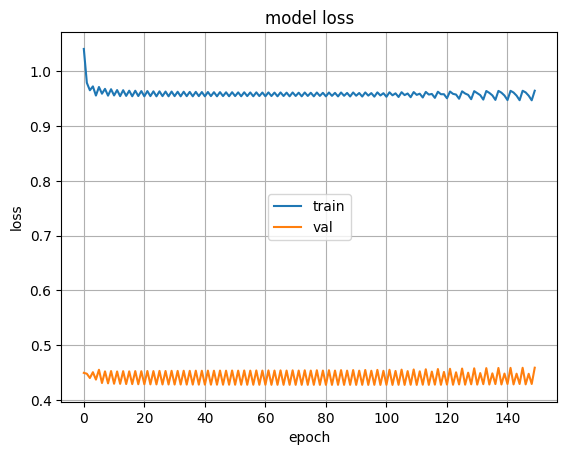

In [38]:
import matplotlib.pyplot as plt

# Graficar pérdida del modelo (loss) en entrenamiento y validación
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')
plt.grid(True)
plt.show()


In [39]:
print("📉 Pérdida en Entrenamiento")
modelo1.evaluate(
    x=x_train,
    y=y_train
)

print("📉 Pérdida en Validación")
modelo1.evaluate(
    x=x_val,
    y=y_val
)

print("📉 Pérdida en Prueba")
modelo1.evaluate(
    x=x_test,
    y=y_test
)


📉 Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9283 - root_mean_squared_error: 0.9635 
📉 Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4589 - root_mean_squared_error: 0.6774
📉 Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3704 - root_mean_squared_error: 0.6086


[0.3703707456588745, 0.6085809469223022]

In [40]:
from pandas import Series

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    i = 0
    for X in data:
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        
        # Invertir normalización
        yhat = scaler.inverse_transform(yhat)
        
        # Invertir diferenciación si es necesario
        if dif:
            yhat = yhat + Series[(n + dif_cant * i)]
        
        prediccion[i] = yhat[0][0]
        i += 1
    return prediccion


In [41]:
# Usamos los datos reales escalados para reconstruir la serie original
prediccion_val = prediccion_fun(x_val, modelo1, 1, scaler, dif=True, dif_cant=1, Series=airPas.values, n=entrenamiento)
prediccion_test = prediccion_fun(x_test, modelo1, 1, scaler, dif=True, dif_cant=1, Series=airPas.values, n=entrenamiento+val_prueba)


In [43]:
len(prediccion_val), len(prediccion_test)
# Usar solo la cantidad exacta de índices necesarios
idx_val = airPas.index[entrenamiento : entrenamiento + len(prediccion_val)]
idx_test = airPas.index[entrenamiento + val_prueba : entrenamiento + val_prueba + len(prediccion_test)]

# Crear DataFrames corregidos
df_val = pd.DataFrame(prediccion_val, index=idx_val)
df_test = pd.DataFrame(prediccion_test, index=idx_test)


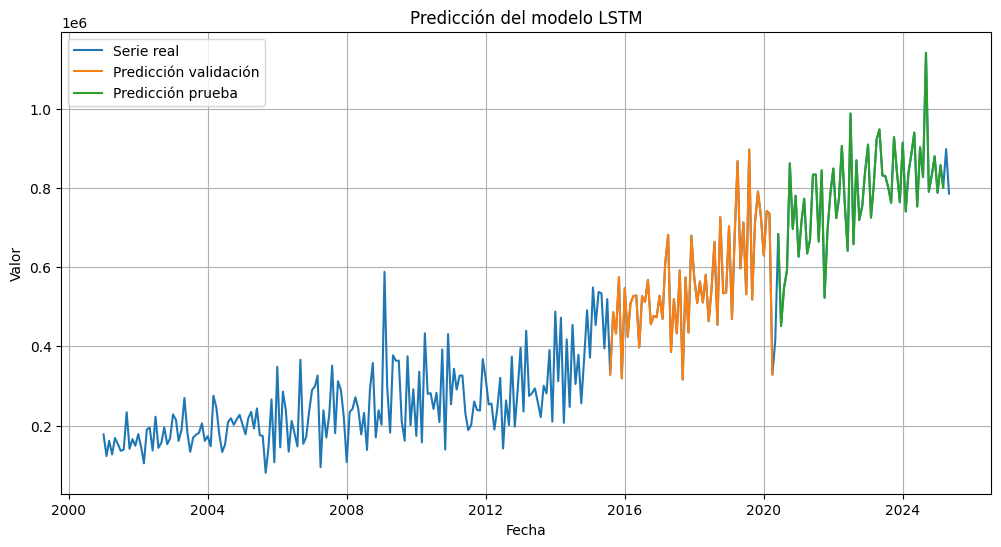

In [44]:
plt.figure(figsize=(12,6))
plt.plot(airPas, label="Serie real")
plt.plot(df_val, label="Predicción validación")
plt.plot(df_test, label="Predicción prueba")
plt.title("Predicción del modelo LSTM")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Asegúrate de que prediccion_test y y_test estén en la misma escala
mae = mean_absolute_error(y_test, prediccion_test)
rmse = np.sqrt(mean_squared_error(y_test, prediccion_test))
r2 = r2_score(y_test, prediccion_test)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 787054.2760
RMSE: 795997.5211
R² Score: -2645099174146.4590


In [46]:
from tensorflow.keras.models import save_model, load_model
import os
os.makedirs("Modelos", exist_ok=True)
save_model(modelo1, "Modelos/lstm1_serie_tiempo.keras")
